### Tutorial 2: Trajectory Optimization for Ergodic Control

References:

[1] *Miller, L.M., Silverman, Y., MacIver, M.A. and Murphey, T.D.*, 2015. **Ergodic exploration of distributed information**. IEEE Transactions on Robotics, 32(1), pp.36-52. [[Link](https://ieeexplore.ieee.org/abstract/document/7350162)]

[2] *Miller, L.M. and Murphey, T.D.*, 2013, June. **Trajectory optimization for continuous ergodic exploration**. In 2013 American Control Conference (pp. 4196-4201). IEEE. [[Link](https://ieeexplore.ieee.org/abstract/document/6580484)]

In [204]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

#### Quick recap on trajectory optimization with iLQR

Consider the following standard formula for an optimal control problem:

$$
\begin{align}
u^*(t) & = {\arg\min}_{u(t)} \int_{0}^{T} l(x(t), u(t)) dt + m(x(T)) \\
s.t. & \quad \dot{x}(t) = f(x(t), u(t)), \quad x(0) = x_0
\end{align}
$$

The iterative linear quadratic regular (iLQR) algorithm follows a gradient descent approach to find a locally optimal solution. Given the current estimation of the control $u(t)$, at each iteration, iLQR finds the descent direction $v(t)$ by solving the following ODEs:

$$
\begin{align}
    & B(t)^\top p(t) + b(t) + R_v^\top v(t) = 0 \\
    & \dot{p}(t) = -A(t)^\top p(t) - a(t) - Q_z^\top z(t) \\
    & \dot{z}(t) = A(t) z(t) + B(t) v(t),
\end{align}
$$ 

with the intial and terminal conditions:

$$
\begin{align}
    z(0) = 0, \quad p(T) = \frac{d}{dx} m(x(T))
\end{align}
$$

where

$$
\begin{align}
    A(t) & = \frac{d}{dx} f(x(t), u(t)) \\
    B(t) & = \frac{d}{du} f(x(t), u(t)) \\
    a(t) & = \frac{d}{dx} l(x(t), u(t)) \\
    b(t) & = \frac{d}{du} l(x(t), u(t)),
\end{align}
$$

and $Q_z$ and $R_v$ are user-defined regularization parameters.

One can solve the ODEs as a two-point boundary value problem or by solving the Riccati equation. We provide a template for the iLQR algorithm below.

In [205]:
class iLQR_template:
    def __init__(self, dt, tsteps, x_dim, u_dim, Q_z, R_v) -> None:
        self.dt = dt 
        self.tsteps = tsteps 

        self.x_dim = x_dim 
        self.u_dim = u_dim

        self.Q_z = Q_z 
        self.Q_z_inv = np.linalg.inv(Q_z)
        self.R_v = R_v 
        self.R_v_inv = np.linalg.inv(R_v)

        self.curr_x_traj = None 
        self.curr_y_traj = None

    def dyn(self, xt, ut):
        raise NotImplementedError("Not implemented.")

    def step(self, xt, ut): 
        """RK4 integration"""
        k1 = self.dt * self.dyn(xt, ut)
        k2 = self.dt * self.dyn(xt + k1/2.0, ut)
        k3 = self.dt * self.dyn(xt + k2/2.0, ut)
        k4 = self.dt * self.dyn(xt + k3, ut)

        xt_new = xt + (k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0 
        return xt_new 
    
    def traj_sim(self, x0, u_traj):
        x_traj = np.zeros((self.tsteps, self.x_dim))
        xt = x0.copy()
        for t_idx in range(self.tsteps):
            xt = self.step(xt, u_traj[t_idx])
            x_traj[t_idx] = xt.copy()
        return x_traj
    
    def loss(self):
        raise NotImplementedError("Not implemented.")
    
    def get_At_mat(self, t_idx):
        raise NotImplementedError("Not implemented.")
    
    def get_Bt_mat(self, t_idx):
        raise NotImplementedError("Not implemented.")

    def get_at_vec(self, t_idx):
        raise NotImplementedError("Not implemented.")
    
    def get_bt_vec(self, t_idx):
        raise NotImplementedError("Not implemented.")

    # the following functions are utilities for solving the Riccati equation
    def P_dyn_rev(self, Pt, At, Bt, at, bt):
        return Pt @ At + At.T @ Pt - Pt @ Bt @ self.R_v_inv @ Bt.T @ Pt + self.Q_z 
    
    def P_dyn_step(self, Pt, At, Bt, at, bt):
        k1 = self.dt * self.P_dyn_rev(Pt, At, Bt, at, bt)
        k2 = self.dt * self.P_dyn_rev(Pt+k1/2, At, Bt, at, bt)
        k3 = self.dt * self.P_dyn_rev(Pt+k2/2, At, Bt, at, bt)
        k4 = self.dt * self.P_dyn_rev(Pt+k3, At, Bt, at, bt)

        Pt_new = Pt + (k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0 
        return Pt_new 
    
    def P_traj_revsim(self, PT, A_traj, B_traj, a_traj, b_traj):
        P_traj_rev = np.zeros((self.tsteps, self.x_dim, self.x_dim))
        P_curr = PT.copy()
        for t in range(self.tsteps):
            At = A_traj[-1-t]
            Bt = B_traj[-1-t]
            at = a_traj[-1-t]
            bt = b_traj[-1-t]

            P_new = self.P_dyn_step(P_curr, At, Bt, at, bt)
            P_traj_rev[t] = P_new.copy()
            P_curr = P_new 
        
        return P_traj_rev

    def r_dyn_rev(self, rt, Pt, At, Bt, at, bt):
        return (At - Bt @ self.R_v_inv @ Bt.T @ Pt).T @ rt + at - Pt @ Bt @ self.R_v_inv @ bt

    def r_dyn_step(self, rt, Pt, At, Bt, at, bt):
        k1 = self.dt * self.r_dyn_rev(rt, Pt, At, Bt, at, bt)
        k2 = self.dt * self.r_dyn_rev(rt+k1/2, Pt, At, Bt, at, bt)
        k3 = self.dt * self.r_dyn_rev(rt+k2/2, Pt, At, Bt, at, bt)
        k4 = self.dt * self.r_dyn_rev(rt+k3, Pt, At, Bt, at, bt)

        rt_new = rt + (k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0 
        return rt_new
    
    def r_traj_revsim(self, rT, P_traj, A_traj, B_traj, a_traj, b_traj):
        r_traj_rev = np.zeros((self.tsteps, self.x_dim))
        r_curr = rT
        for t in range(self.tsteps):
            Pt = P_traj[-1-t]
            At = A_traj[-1-t]
            Bt = B_traj[-1-t]
            at = a_traj[-1-t]
            bt = b_traj[-1-t]

            r_new = self.r_dyn_step(r_curr, Pt, At, Bt, at, bt)
            r_traj_rev[t] = r_new.copy()
            r_curr = r_new 

        return r_traj_rev

    def z_dyn(self, zt, Pt, rt, At, Bt, bt):
        return At @ zt + Bt @ self.z2v(zt, Pt, rt, Bt, bt)
    
    def z_dyn_step(self, zt, Pt, rt, At, Bt, bt):
        k1 = self.dt * self.z_dyn(zt, Pt, rt, At, Bt, bt)
        k2 = self.dt * self.z_dyn(zt+k1/2, Pt, rt, At, Bt, bt)
        k3 = self.dt * self.z_dyn(zt+k2/2, Pt, rt, At, Bt, bt)
        k4 = self.dt * self.z_dyn(zt+k3, Pt, rt, At, Bt, bt)

        zt_new = zt + (k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0 
        return zt_new

    def z_traj_sim(self, z0, P_traj, r_traj, A_traj, B_traj, b_traj):
        z_traj = np.zeros((self.tsteps, self.x_dim))
        z_curr = z0.copy()

        for t in range(self.tsteps):
            Pt = P_traj[t]
            rt = r_traj[t]
            At = A_traj[t]
            Bt = B_traj[t]
            bt = b_traj[t]

            z_new = self.z_dyn_step(z_curr, Pt, rt, At, Bt, bt)
            z_traj[t] = z_new.copy()
            z_curr = z_new
        
        return z_traj
    
    def z2v(self, zt, Pt, rt, Bt, bt):
        return -self.R_v_inv @ Bt.T @ Pt @ zt - self.R_v_inv @ Bt.T @ rt - self.R_v_inv @ bt

    def get_descent(self, x0, u_traj):
        # forward simulate the trajectory
        x_traj = self.traj_sim(x0, u_traj)
        self.curr_x_traj = x_traj.copy()
        self.curr_u_traj = u_traj.copy()

        # sovle the Riccati equation backward in time
        A_traj = np.zeros((self.tsteps, self.x_dim, self.x_dim))
        B_traj = np.zeros((self.tsteps, self.x_dim, self.u_dim))
        a_traj = np.zeros((self.tsteps, self.x_dim))
        b_traj = np.zeros((self.tsteps, self.u_dim))

        for t_idx in range(self.tsteps):
            A_traj[t_idx] = self.get_At_mat(t_idx)
            B_traj[t_idx] = self.get_Bt_mat(t_idx)
            a_traj[t_idx] = self.get_at_vec(t_idx)
            b_traj[t_idx] = self.get_bt_vec(t_idx)

        # print('a_traj:\n', a_traj)
        
        PT = np.zeros((self.x_dim, self.x_dim))
        P_traj_rev = self.P_traj_revsim(PT, A_traj, B_traj, a_traj, b_traj)
        P_traj = np.flip(P_traj_rev, axis=0)

        rT = np.zeros(self.x_dim)
        r_traj_rev = self.r_traj_revsim(rT, P_traj, A_traj, B_traj, a_traj, b_traj)
        r_traj = np.flip(r_traj_rev, axis=0)

        z0 = np.zeros(self.x_dim)
        z_traj = self.z_traj_sim(z0, P_traj, r_traj, A_traj, B_traj, b_traj)

        # compute the descent direction
        v_traj = np.zeros((self.tsteps, self.u_dim))
        for t in range(self.tsteps):
            zt = z_traj[t]
            Pt = P_traj[t]
            rt = r_traj[t]
            Bt = B_traj[t]
            bt = b_traj[t]
            v_traj[t] = self.z2v(zt, Pt, rt, Bt, bt)
        
        return v_traj

To formulate a trajectory optimization problem for ergodic control, we define the following objective:

$$
u^*(t) = {\arg\min}_{u(t)} \text{ } \mathcal{E}(s(t), P(x)) + \int_0^T \frac{1}{2} u(t) R^\top u(t) dt
$$

Recall that the ergodic metric $\mathcal{E}(s(t), P(x))$ is formulated as follow:

$$
\mathcal{E}(p(x), s(t)) = \sum_{k} \lambda_k \cdot (c_k - \phi_k)^2
$$

In this case, in order to compute the descent direction, we have:

$$
\begin{align}
    a(t) & = \sum_k \lambda_k \left[ 2 \left( \frac{1}{T}\int_{0}^{T} f_k(x(\tau)) d\tau - \phi_k \right) \cdot \frac{1}{T} \nabla f_k(x(t)) \right] \\
    b(t) & = R^\top u(t),
\end{align}
$$

We now implement the above iLQR ergodic control formula using the template code. We are going to optimize the trajectory of the same first-order system over the same Gaussian-mixture target distribution defined in the previous tutorial. The difference here is we are optimizing the ergodicity over the entire time horizon of the trajectory, 

In [206]:
class iLQR_ergodic_pointmass(iLQR_template):
    def __init__(self, dt, tsteps, x_dim, u_dim, Q_z, R_v,
                 R, ks, L_list, lamk_list, hk_list, phik_list) -> None:
        super().__init__(dt, tsteps, x_dim, u_dim, Q_z, R_v)
        
        self.R = R 
        self.ks = ks 
        self.L_list = L_list
        self.lamk_list = lamk_list 
        self.hk_list = hk_list 
        self.phik_list = phik_list 

    def dyn(self, xt, ut):
        return ut
        
    def get_At_mat(self, t_idx):
        A = np.zeros((self.x_dim, self.x_dim))
        return A
    
    def get_Bt_mat(self, t_idx):
        B = np.eye(self.u_dim)
        return B

    def get_at_vec(self, t_idx):
        xt = self.curr_x_traj[t_idx][:2]
        x_traj = self.curr_x_traj[:,:2]
        
        dfk_xt_all = np.array([
            -np.pi * self.ks[:,0] / self.L_list[0] * np.sin(np.pi * self.ks[:,0] / self.L_list[0] * xt[0]) * np.cos(np.pi * self.ks[:,1] / self.L_list[1] * xt[1]),
            -np.pi * self.ks[:,1] / self.L_list[1] * np.cos(np.pi * self.ks[:,0] / self.L_list[0] * xt[0]) * np.sin(np.pi * self.ks[:,1] / self.L_list[1] * xt[1]),
        ]) / self.hk_list

        fk_all = np.prod(np.cos(np.pi * self.ks / self.L_list * x_traj[:,None]), axis=2) / self.hk_list
        ck_all = np.sum(fk_all, axis=0) * self.dt / (self.tsteps * self.dt)

        at = np.sum(self.lamk_list * 2.0 * (ck_all - self.phik_list) * dfk_xt_all / (self.tsteps * self.dt), axis=1)
        return at

    def get_bt_vec(self, t_idx):
        ut = self.curr_u_traj[t_idx]
        return self.R @ ut 
    
    def loss(self, x_traj, u_traj):
        fk_all = np.prod(np.cos(np.pi * self.ks / self.L_list * x_traj[:,None]), axis=2) / self.hk_list
        ck_all = np.sum(fk_all, axis=0) * self.dt / (self.tsteps * self.dt)
        erg_metric = np.sum(self.lamk_list * np.square(ck_all - self.phik_list))

        ctrl_cost = np.sum(self.R @ u_traj.T * u_traj.T) * self.dt 
        return erg_metric + ctrl_cost 

In [207]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.5

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])
w3 = 0.3

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3)

# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], 100),
    np.linspace(0, L_list[1], 100)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / 99
dy = 1.0 / 99 

In [208]:
# Configure the index vectors
num_k_per_dim = 10
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T

# Pre-processing lambda_k and h_k
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
hk_list = np.zeros(ks.shape[0])
for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    hk_list[i] = hk

# compute the coefficients for the target distribution
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, (k_vec, hk) in enumerate(zip(ks, hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    fk_vals /= hk

    phik = np.sum(fk_vals * pdf_vals) * dx * dy 
    phik_list[i] = phik

In [209]:
# Define the optimal control problem 
dt = 0.1 
tsteps = 100
R = np.diag([0.0001, 0.0001])
Q_z = np.diag([0.01, 0.01])
R_v = np.diag([0.01, 0.01])
x0 = np.random.uniform(low=0.4, high=0.6, size=(2,))
init_u_traj = np.tile(np.array([1e-06, 1e-06]), reps=(tsteps,1))

In [210]:
trajopt_ergodic_pointmass = iLQR_ergodic_pointmass(
    dt, tsteps, x_dim=2, u_dim=2, Q_z=Q_z, R_v=R_v,
    R=R, ks=ks, L_list=L_list, lamk_list=lamk_list,
    hk_list=hk_list, phik_list=phik_list
)

Once we have the descent direction, we can find a step size (such as through Armijo backtracking line search) and iteratively update the control. In the example here, we simply choose a small constant step size to demonstrate the algorithm.

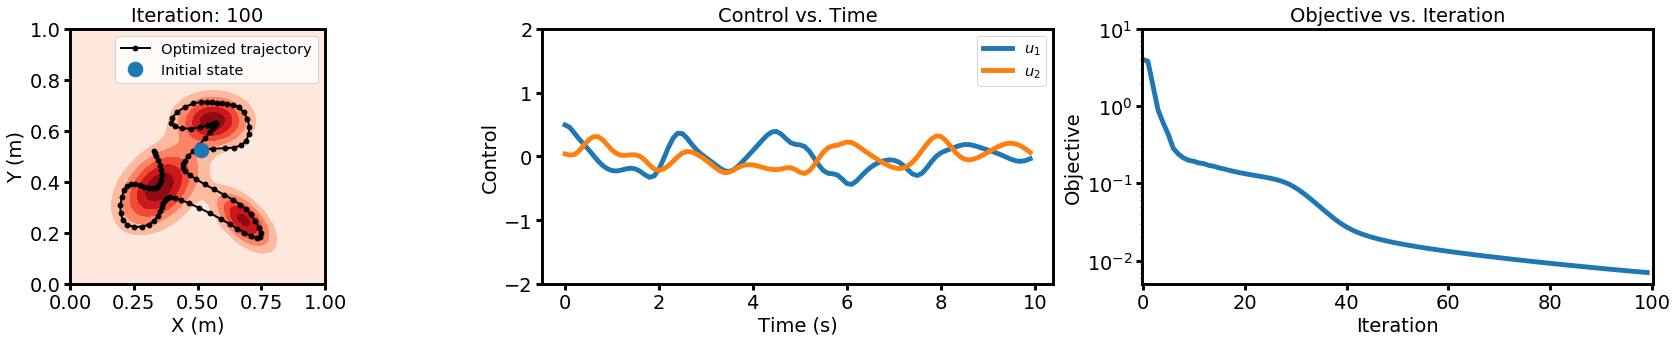

In [211]:
# Iterative trajectory optimization for ergodic control
from IPython import display

u_traj = init_u_traj.copy()
step = 0.01
loss_list = []

fig, axes = plt.subplots(1, 3, dpi=70, figsize=(25,5), tight_layout=True)

for iter in tqdm(range(100)):
    x_traj = trajopt_ergodic_pointmass.traj_sim(x0, u_traj)
    v_traj = trajopt_ergodic_pointmass.get_descent(x0, u_traj)

    loss_val = trajopt_ergodic_pointmass.loss(x_traj, u_traj)
    loss_list.append(loss_val)

    step = 0.001
    u_traj += step * v_traj

    # visualize every 10 iterations
    if (iter+1) % 10 == 0:
        ax1 = axes[0]
        ax1.cla()
        ax1.set_aspect('equal', adjustable='box')
        ax1.set_xlim(0.0, L_list[0])
        ax1.set_ylim(0.0, L_list[1])
        ax1.set_title('Iteration: {:d}'.format(iter+1))
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
        ax1.plot([x0[0], x_traj[0,0]], [x0[1], x_traj[0,1]], linestyle='-', linewidth=2, color='k', alpha=1.0)
        ax1.plot(x_traj[:,0], x_traj[:,1], linestyle='-', marker='o', color='k', linewidth=2, alpha=1.0, label='Optimized trajectory')
        ax1.plot(x0[0], x0[1], linestyle='', marker='o', markersize=15, color='C0', alpha=1.0, label='Initial state')
        ax1.legend(loc=1)

        ax2 = axes[1]
        ax2.cla()
        ax2.set_title('Control vs. Time')
        ax2.set_ylim(-2.0, 2.0)
        ax2.plot(np.arange(tsteps)*dt, u_traj[:,0], color='C0', label=r'$u_1$')
        ax2.plot(np.arange(tsteps)*dt, u_traj[:,1], color='C1', label=r'$u_2$')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Control')
        ax2.legend(loc=1)
        height = ax1.get_position().height
        ax2.set_position([ax2.get_position().x0, ax1.get_position().y0, ax2.get_position().width, height])

        ax3 = axes[2]
        ax3.cla()
        ax3.set_title('Objective vs. Iteration')
        ax3.set_xlim(-0.2, 100.2)
        ax3.set_ylim(5e-3, 1e01)
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Objective')
        ax3.plot(np.arange(iter+1), loss_list, color='C0')
        height = ax1.get_position().height
        ax3.set_position([ax3.get_position().x0, ax1.get_position().y0, ax3.get_position().width, height])
        ax3.set_yscale('log')

        display.clear_output(wait=True)
        display.display(fig)

display.clear_output(wait=True)
plt.show()
plt.close()

The advantage of the trajectory optimization formula is that, we can apply it to other non-linear systems. Below we show an example of optimization the ergodic trajectory for a differential-drive robot.

In [212]:
class iLQR_ergodic_diffdrive(iLQR_template):
    def __init__(self, dt, tsteps, x_dim, u_dim, Q_z, R_v,
                 R, ks, L_list, lamk_list, hk_list, phik_list) -> None:
        super().__init__(dt, tsteps, x_dim, u_dim, Q_z, R_v)
        
        self.R = R 
        self.ks = ks 
        self.L_list = L_list
        self.lamk_list = lamk_list 
        self.hk_list = hk_list 
        self.phik_list = phik_list 

    def dyn(self, xt, ut):
        xdot = np.array([
            ut[0] * np.cos(xt[2]),
            ut[0] * np.sin(xt[2]),
            ut[1]
        ])
        return xdot 
        
    def get_At_mat(self, t_idx):
        xt = self.curr_x_traj[t_idx]
        ut = self.curr_u_traj[t_idx]
        A = np.array([
            [0.0, 0.0, -np.sin(xt[2]) * ut[0]],
            [0.0, 0.0,  np.cos(xt[2]) * ut[0]],
            [0.0, 0.0, 0.0]
        ])
        return A
    
    def get_Bt_mat(self, t_idx):
        xt = self.curr_x_traj[t_idx]
        B = np.array([
            [np.cos(xt[2]), 0.0],
            [np.sin(xt[2]), 0.0],
            [0.0, 1.0]
        ])
        return B

    def get_at_vec(self, t_idx):
        xt = self.curr_x_traj[t_idx][:2]
        x_traj = self.curr_x_traj[:,:2]
        
        dfk_xt_all = np.array([
            -np.pi * self.ks[:,0] / self.L_list[0] * np.sin(np.pi * self.ks[:,0] / self.L_list[0] * xt[0]) * np.cos(np.pi * self.ks[:,1] / self.L_list[1] * xt[1]),
            -np.pi * self.ks[:,1] / self.L_list[1] * np.cos(np.pi * self.ks[:,0] / self.L_list[0] * xt[0]) * np.sin(np.pi * self.ks[:,1] / self.L_list[1] * xt[1]),
        ]) / self.hk_list

        fk_all = np.prod(np.cos(np.pi * self.ks / self.L_list * x_traj[:,None]), axis=2) / self.hk_list
        ck_all = np.sum(fk_all, axis=0) * self.dt / (self.tsteps * self.dt)

        at = np.sum(self.lamk_list * 2.0 * (ck_all - self.phik_list) * dfk_xt_all / (self.tsteps * self.dt), axis=1)
        return np.array([at[0], at[1], 0.0])

    def get_bt_vec(self, t_idx):
        ut = self.curr_u_traj[t_idx]
        return self.R @ ut 
    
    def loss(self, x_traj, u_traj):
        fk_all = np.prod(np.cos(np.pi * self.ks / self.L_list * x_traj[:,:2][:,None]), axis=2) / self.hk_list
        ck_all = np.sum(fk_all, axis=0) * self.dt / (self.tsteps * self.dt)
        erg_metric = np.sum(self.lamk_list * np.square(ck_all - self.phik_list))

        ctrl_cost = np.sum(self.R @ u_traj.T * u_traj.T) * self.dt 
        return erg_metric + ctrl_cost 

In [213]:
# Define the optimal control problem 
dt = 0.1 
tsteps = 100
R = np.diag([0.01, 0.01])
Q_z = np.diag([0.01, 0.01, 0.001])
R_v = np.diag([0.002, 0.001])
x0 = np.zeros(3)
x0[:2] = np.random.uniform(low=0.4, high=0.6, size=(2,))
init_u_traj = np.tile(np.array([0.2, 1.2]), reps=(tsteps,1))

In [214]:
trajopt_ergodic_diffdrive = iLQR_ergodic_diffdrive(
    dt, tsteps, x_dim=3, u_dim=2, Q_z=Q_z, R_v=R_v,
    R=R, ks=ks, L_list=L_list, lamk_list=lamk_list,
    hk_list=hk_list, phik_list=phik_list
)

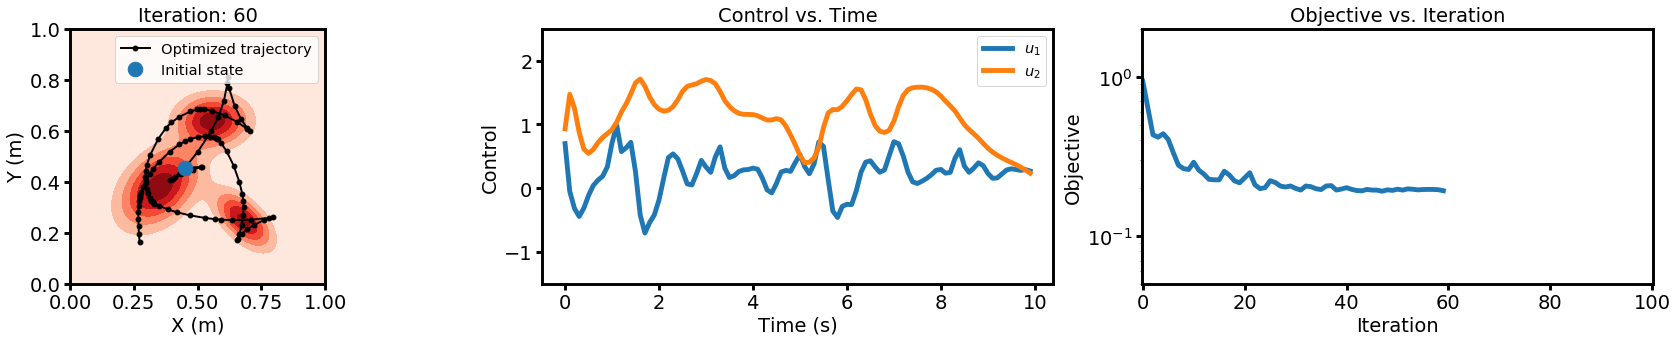

 60%|██████    | 60/100 [00:05<00:03, 10.79it/s]


KeyboardInterrupt: 

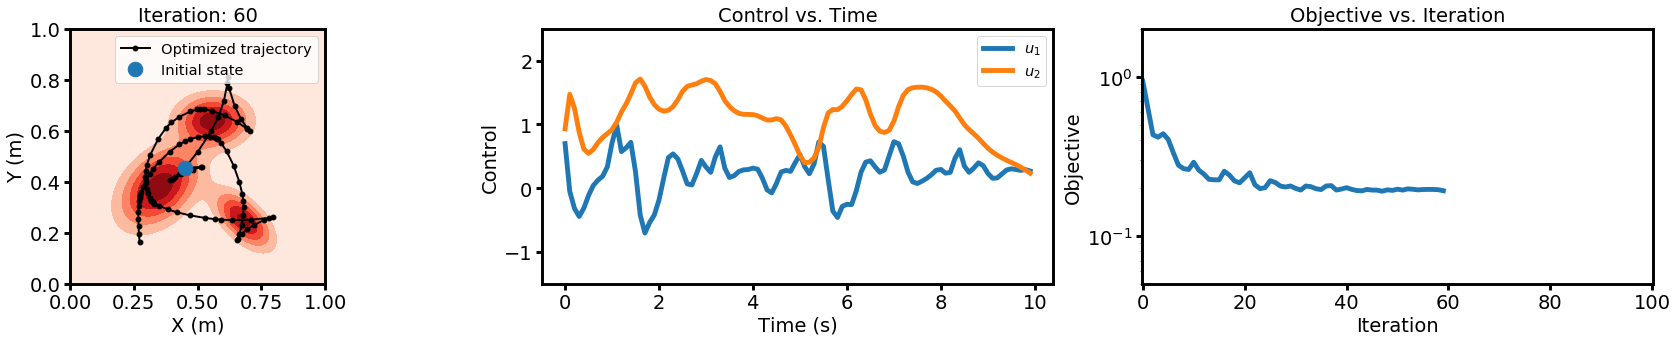

In [233]:
# Iterative trajectory optimization for ergodic control
from IPython import display

u_traj = init_u_traj.copy()
step = 0.01
loss_list = []

fig, axes = plt.subplots(1, 3, dpi=70, figsize=(25,5), tight_layout=True)

for iter in tqdm(range(100)):
    x_traj = trajopt_ergodic_diffdrive.traj_sim(x0, u_traj)
    v_traj = trajopt_ergodic_diffdrive.get_descent(x0, u_traj)

    loss_val = trajopt_ergodic_diffdrive.loss(x_traj, u_traj)
    loss_list.append(loss_val)

    step = 0.003
    u_traj += step * v_traj

    # visualize every 10 iterations
    if (iter+1) % 10 == 0:
        ax1 = axes[0]
        ax1.cla()
        ax1.set_aspect('equal', adjustable='box')
        ax1.set_xlim(0.0, L_list[0])
        ax1.set_ylim(0.0, L_list[1])
        ax1.set_title('Iteration: {:d}'.format(iter+1))
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
        ax1.plot([x0[0], x_traj[0,0]], [x0[1], x_traj[0,1]], linestyle='-', linewidth=2, color='k', alpha=1.0)
        ax1.plot(x_traj[:,0], x_traj[:,1], linestyle='-', marker='o', color='k', linewidth=2, alpha=1.0, label='Optimized trajectory')
        ax1.plot(x0[0], x0[1], linestyle='', marker='o', markersize=15, color='C0', alpha=1.0, label='Initial state')
        ax1.legend(loc=1)

        ax2 = axes[1]
        ax2.cla()
        ax2.set_title('Control vs. Time')
        ax2.set_ylim(-1.5, 2.5)
        ax2.plot(np.arange(tsteps)*dt, u_traj[:,0], color='C0', label=r'$u_1$')
        ax2.plot(np.arange(tsteps)*dt, u_traj[:,1], color='C1', label=r'$u_2$')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Control')
        ax2.legend(loc=1)
        height = ax1.get_position().height
        ax2.set_position([ax2.get_position().x0, ax1.get_position().y0, ax2.get_position().width, height])

        ax3 = axes[2]
        ax3.cla()
        ax3.set_title('Objective vs. Iteration')
        ax3.set_xlim(-0.2, 100.2)
        ax3.set_ylim(5e-2, 2.0)
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Objective')
        ax3.plot(np.arange(iter+1), loss_list, color='C0')
        height = ax1.get_position().height
        ax3.set_position([ax3.get_position().x0, ax1.get_position().y0, ax3.get_position().width, height])
        ax3.set_yscale('log')

        # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
        display.clear_output(wait=True)
        display.display(fig)

display.clear_output(wait=True)
plt.show()
plt.close()